![](../images/w2slides/Slide1.JPG)

![](../images/w2slides/Slide2.JPG)

![](../images/w2slides/Slide3.JPG)

![](../images/w2slides/Slide4.JPG)

![](../images/w2slides/Slide5.JPG)

![](../images/w2slides/Slide6.JPG)

![](../images/w2slides/Slide7.JPG)

![](../images/w2slides/Slide8.JPG)

![](../images/w2slides/Slide9.JPG)

![](../images/w2slides/Slide10.JPG)

![](../images/w2slides/Slide11.JPG)

![](../images/w2slides/Slide12.JPG)

![](../images/w2slides/Slide13.JPG)

![](../images/w2slides/Slide14.JPG)

![](../images/w2slides/Slide15.JPG)

## Convolution Demo Run
___
* This notebook shows a single run of the convolution using CNNDataflow IP.  

 
* The input feature map is read from memory, processed and output feature map is captured for one single convolution command.   
* The cycle count and efficiency for the full operation is read and displayed at the end.   
* The input data in memory is set with random integers in this notebook to test the convolution run.

#### Terminology
| Term    | Description                              |
| :------ | :--------------------------------------- |
| IFM     | Input volume                             |
| Weights | A set of filter volumes                  |
| OFM     | Output volume.                           |

#### Arguments
| Convolution Arguments | Description                              |
| --------------------- | ---------------------------------------- |
| ifm-h, ifm-w          | Height and width of an input feature map in an IFM volume |
| ifm-d                 | Depth of the IFM volume                  |
| kernel-h, kernel-w    | Height and width of the weight filters   |
| stride                | Stride for the IFM volume                |
| pad                   | Pad for the IFM volume                   |
| Channels              | Number of Weight sets/number of output feature maps |

### Block diagram

![](../images/darius_bd.png)
Figure 1

Figure 1 presents a simplified block diagram including Darius CNN IP that is used for running convolution tasks. The Processing System (PS) represents the ARM processor, as well as the external DDR. The Programmable Logic (PL) incorporates the Darius IP for running convolution tasks, and an AXI Interconnect IP. The AXI_GP_0 is an AXILite interface for control signal communication between the ARM and the Darius IP. The data transfer happens through the AXI High Performance Bus, denoted as AXI_HP_0. __For more information about the Zynq architecture, visit:__ [Link](https://www.xilinx.com/support/documentation/user_guides/ug585-Zynq-7000-TRM.pdf)


### Dataflow   

The dataflow begins by creating an input volume, and a set of weights in python local memory. In Figure 1, these volumes are denoted as “ifm_sw”, and “weights_sw”, respectively. After populating random data, the ARM processor reshapes and copies these volumes into contiguous blocks of shared memory, represented as “ifm” and “weights” in Figure 1, using the “copy_and_reshape()” function. Once the data is accessible by the hardware, the PS starts the convolution operation by asserting the start bit of Darius IP, through the “AXI_GP_0” interface. Darius starts the processing by reading the “ifm” and “weights” volumes from the external memory and writing the results back to a pre-allocated location, shown as “ofm” in Figure 1.
Notes:
-	We presume the data in the “ifm_sw” and “weight_sw”, are populated in a row-major format. In order to get the correct results, these volumes have to be reshaped into an interleaved format, as expected by the Darius IP. 
-	No data reformatting is required for subsequent convolution calls to Darius, as it produces the “ofm” volume in the same format as it expects the “ifm” volume.
-	Since the shared memory region is accessible both by the PS and PL regions, one can perform any post-processing steps that may be required directly on the “ofm” volume without transferring data back-and-forth to the python local memory. 


### Step 1: Set the arguments for the convolution in CNNDataflow IP

In [1]:
# Input Feature Map (IFM) dimensions
ifm_height = 14
ifm_width = 14
ifm_depth = 64

# Kernel Window dimensions
kernel_height = 3
kernel_width = 3

# Other arguments
pad = 0
stride = 1

# Channels
channels = 32

print(
    "HOST CMD: CNNDataflow IP Arguments set are - IH %d, IW %d, ID %d, KH %d,"
    " KW %d, P %d, S %d, CH %d"
    % (ifm_height, ifm_width, ifm_depth, kernel_height, kernel_width,
       pad, stride, channels))

HOST CMD: CNNDataflow IP Arguments set are - IH 14, IW 14, ID 64, KH 3, KW 3, P 0, S 1, CH 32


### Step 2: Download `Darius Convolution IP` bitstream

In [2]:
from pynq import Overlay

overlay = Overlay(
    "/opt/python3.6/lib/python3.6/site-packages/pynq/overlays/darius/"
    "convolution.bit")
overlay.download()
print(f'Bitstream download status: {overlay.is_loaded()}')

Bitstream download status: True


### Step 3:  Create MMIO object to access the CNNDataflow IP
For more on MMIO visit: [MMIO Documentation](http://pynq.readthedocs.io/en/latest/overlay_design_methodology/pspl_interface.html#mmio)

In [3]:
from pynq import MMIO

# Constants
CNNDATAFLOW_BASEADDR = 0x43C00000
NUM_COMMANDS_OFFSET = 0x60
CMD_BASEADDR_OFFSET = 0x70
CYCLE_COUNT_OFFSET = 0xd0

cnn = MMIO(CNNDATAFLOW_BASEADDR, 65536)
print(f'Idle state: {hex(cnn.read(0x0, 4))}')

Idle state: 0x4


### Step 4: Create Xlnk object 
Xlnk object (Memory Management Unit) for allocating contiguous array in memory for data transfer between software and hardware

<div class="alert alert-danger">Note: You may run into problems if you exhaust and do not free memory buffers – we only have 128MB of contiguous memory, so calling the allocation twice (allocating 160MB) would lead to a “failed to allocate memory” error. Do a xlnk_reset() before re-allocating memory or running this cell twice  </div>

In [4]:
from pynq import Xlnk
import numpy as np

# Constant
SIZE = 5000000  # 20 MB of numpy.uint32s
mmu = Xlnk()

cmd = mmu.cma_array(SIZE)
ifm = mmu.cma_array(SIZE)
weights = mmu.cma_array(SIZE)
ofm = mmu.cma_array(SIZE)

cmd_baseaddr = cmd.physical_address
ifm_baseaddr = ifm.physical_address
weights_baseaddr = weights.physical_address
ofm_baseaddr = ofm.physical_address

### Step 5: Functions to print Xlnk statistics

In [5]:
def get_kb(mmu):
    return int(mmu.cma_stats()['CMA Memory Available'] // 1024)


def get_bufcount(mmu):
    return int(mmu.cma_stats()['Buffer Count'])


def print_kb(mmu):
    print("Available Memory (KB): " + str(get_kb(mmu)))
    print("Available Buffers: " + str(get_bufcount(mmu)))


print_kb(mmu)

Available Memory (KB): 29708
Available Buffers: 4


### Step 6: Construct convolution command
Check that arguments are in supported range and construct convolution command for hardware

In [6]:
from darius import cnndataflow_lib

conv = cnndataflow_lib.CNNDataflow(ifm_height, ifm_width, ifm_depth,
                                   kernel_height, kernel_width, pad, stride,
                                   channels, ifm_baseaddr, weights_baseaddr,
                                   ofm_baseaddr)

conv.construct_conv_cmd(ifm_height, ifm_width, ifm_depth, kernel_height,
                        kernel_width, pad, stride, channels, ifm_baseaddr,
                        weights_baseaddr, ofm_baseaddr)

All convolution arguments are in supported range
Convolution command to CNNDataflow IP: 
b'\x0e\x00\x0e\x00\x03\x00\x03\x00\x01\x00\x00\x00\x0c\x00\x0c\x00\x08\x00\x04\x00\x01\x00\x01\x00\x00\x00\xd0\x17 \x06\x00\x00\x001\x00\x00\x00\x00\x00\x00\x00\x00P\x1a@\x02\x00\x00\x00\x00\x10\x19@\x02\x00\x00\x00\x12\x00\x00\x00\x00\x00\x00'


### Step 7: Create IFM volume and weight volume.
Volumes are created in software and populated with random values in a row-major format.

In [7]:
from random import *

ifm_sw = np.empty(ifm_width * ifm_height * ifm_depth, dtype=np.int16)

for i in range(0, ifm_depth):
    for j in range(0, ifm_height):
        for k in range(0, ifm_width):
            index = i * ifm_height * ifm_width + j * ifm_width + k
            ifm_sw[index] = randint(0, 255)

weights_sw = np.empty(channels * ifm_depth * kernel_height * kernel_width,
                      dtype=np.int16)

for i in range(0, channels):
    for j in range(0, ifm_depth):
        for k in range(0, kernel_height * kernel_width):
            addr = i * ifm_depth * kernel_height * kernel_width + \
                   j * kernel_height * kernel_width + k
            weights_sw[addr] = randint(0, 255)

#### Reshape IFM volume and weights
Volumes are reshaped from row-major format to IP format and data is copied to their respective shared buffer

In [8]:
conv.reshape_and_copy_ifm(ifm_height, ifm_width, ifm_depth, ifm_sw, ifm)
conv.reshape_and_copy_weights(kernel_height, kernel_width, ifm_depth,
                              weights_sw, weights)

### Step 8: Load  convolution command and start CNNDataflow IP

In [9]:
# Send convolution command to CNNDataflow IP
conv.load_conv_cmd(cmd_baseaddr)

# Load the number of commands and command physical address to offset addresses
cnn.write(NUM_COMMANDS_OFFSET, 1)
cnn.write(CMD_BASEADDR_OFFSET, cmd_baseaddr)

# Start Convolution if CNNDataflow IP is in Idle state
state = cnn.read(0x0)
if state == 4: # Idle state
    print("state: IP IDLE; hence Starting IP")
    start = cnn.write(0x0, 1) # Start IP
    start
else:
    print("state %x: IP BUSY" % state)

state: IP IDLE; hence Starting IP


#### Check status of the CNNDataflow IP

In [10]:
# Check if Convolution IP is in Done state
state = cnn.read(0x0)
if state == 6: # Done state
    print("state: IP DONE")
else:
    print("state %x: IP BUSY" % state)

state: IP DONE


### Step 9: Read back first few words of OFM

In [11]:
for i in range(0, 15, 4):
    print(hex(ofm[i]))

0xc47d
0xe946
0xc9cb
0x3911


### Step 10: Read cycle count and efficiency of the complete run

In [12]:
hw_cycles = cnn.read(CYCLE_COUNT_OFFSET, 4)
efficiency = conv.calc_efficiency(kernel_height, kernel_width, ifm_depth,
                                  hw_cycles)
print("CNNDataflow IP cycles: %d\nEffciency: %.2f%%" % (hw_cycles, efficiency))


CNNDataflow IP cycles: 44196
Effciency: 93.84%


#### Reset Xlnk

In [13]:
mmu.xlnk_reset()
print_kb(mmu)
print("Cleared Memory!")

Available Memory (KB): 106740
Available Buffers: 0
Cleared Memory!


![](../images/w2slides/Slide16.JPG)

![](../images/w2slides/Slide17.JPG)

![](../images/w2slides/Slide18.JPG)

![](../images/w2slides/Slide19.JPG)

![](../images/w2slides/Slide20.JPG)

# Resizing an image
This reference design illustrates how to run a kernel for resizing an image on the FPGA.

## Hardware
A simplified block diagram is shown below:

![](../images/resize_bd.png)

## Software
The software enables users to run the kernel on the fpga and display the results in the notebook.

### Step 1: Import libraries

In [14]:
import sys
import math
import numpy as np
import os
import time
from PIL import Image
from matplotlib import pyplot
import cv2
from pynq import Xlnk
from pynq import Overlay


### Step 2. Download the `Resize IP` bitstream

In [15]:
overlay = Overlay("/opt/python3.6/lib/python3.6/site-packages/pynq/overlays/resize/resize.bit") 
dma = overlay.axi_dma_0
kernel = overlay.resize_accel_0

### Step 3: View image that is to be re-sized
The picture pixel data can be read using `opencv` library.


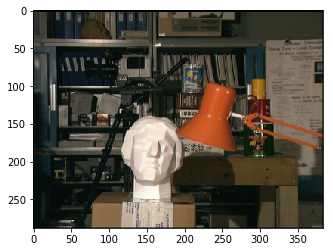

Original image size: 288x384 pixels.


In [16]:
interval_time = 0
image_path = "../images/img_l.png"
original_image = Image.open(image_path)
original_array = np.array(original_image)
original_image.close()

pyplot.imshow(original_array, interpolation='nearest')
pyplot.show()

old_width, old_height = original_image.size
print("Original image size: {}x{} pixels.".format(old_height, old_width))

### Step 4: Resize in software and  display the time profile
__Note: The software example you will notice is quite slow.__ 

In [17]:
new_width, new_height = int(old_width/2), int(old_height/2)
original_image = Image.open(image_path)

%timeit resized_image = original_image.resize((new_width, new_height), Image.ANTIALIAS)

31.5 ms ± 51.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Display SW re-sized image

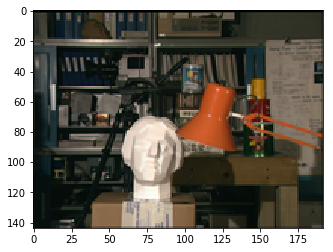

Resized image size: 144x192 pixels.


In [18]:
resized_image = original_image.resize((new_width, new_height), Image.ANTIALIAS)

orig_image_array = np.array(original_image)
resized_array = np.array(resized_image)
original_image.close()

pyplot.imshow(resized_array, interpolation='nearest')
pyplot.show()

width, height = resized_image.size
print("Resized image size: {}x{} pixels.".format(height, width))

### Step 5: Allocating memory to process data on PL
Data is provided through contiguous memory locations.

The size of the buffer depends on the size of the input or output data.
The image dimensions extracted from the read image are used to allocate contiguous memory as follows.
We will use `cma_array` of the corresponding size.

In [19]:
xlnk = Xlnk()
in_buffer = xlnk.cma_array(shape=(old_height, old_width, 3), dtype=np.uint8)
out_buffer = xlnk.cma_array(shape=(new_height, new_width, 3), dtype=np.uint8)

__Note: In the following example, we are only dealing with one image. We will just send one image to the kernel and obtain the results.__

__Also Note: The `orig_image_array` has to be copied into the contiguous memory array(deep copy).__

#### Display the image in buffer

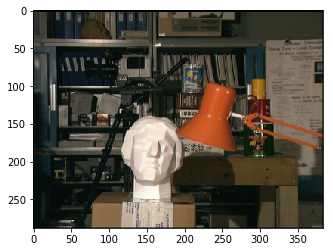

In [20]:
interval_time = 0
in_buffer[:] = orig_image_array

pyplot.imshow(in_buffer)
pyplot.show()


### Step 6:  Resize in hardware and display image

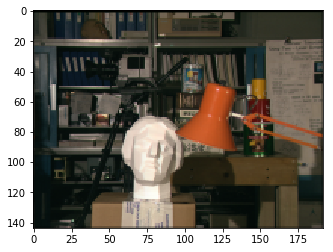

In [21]:
kernel.write(0x10, old_height)
kernel.write(0x18, old_width)
kernel.write(0x20, new_height)
kernel.write(0x28, new_width)

def run_kernel():
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)
    kernel.write(0x00,0x81)
    dma.sendchannel.wait()
    dma.recvchannel.wait()

run_kernel()

pyplot.imshow(out_buffer)
pyplot.show()

### Step 7: Time profile resize in HW

In [22]:
%%timeit

#src_rows
kernel.write(0x10, old_height)
#src_cols
kernel.write(0x18, old_width)
#dst_rows
kernel.write(0x20, new_height)
#dst_cols
kernel.write(0x28, new_width)

def run_kernel():
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)
    kernel.write(0x00,0x81)
    dma.sendchannel.wait()
    dma.recvchannel.wait()

run_kernel()

2.24 ms ± 2.51 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Reset Xlnk

In [23]:
xlnk.xlnk_reset()

![](../images/w2slides/Slide21.JPG)

![](../images/w2slides/Slide22.JPG)

![](../images/w2slides/Slide23.JPG)

![](../images/w2slides/Slide24.JPG)

![](../images/w2slides/Slide25.JPG)

![](../images/w2slides/Slide26.JPG)